In [1]:
import random
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('artifact_database.csv')
# df = pd.read_csv('artifact_database_full.csv')

In [3]:
def set_sim(num_sample, the_condition):
    
    df_sample = df.sample(num_sample)
    
    # balance = weight * er + weight * em, weight is the average substat num
    
    df1 = df_sample[ (df_sample["position"] == "flower") ].copy()
    df2 = df_sample[ (df_sample["position"] == "plume") ].copy()
    
    df1["clip"] = 0
    df1["cnt"] = 0
    df2["clip"] = 0
    df2["cnt"] = 0
    
    for idx, the_sub in enumerate(the_condition["sub"]):
        df1["clip"] = df1["clip"] + (df1[the_sub] / the_condition["unit_value"][idx]).clip(upper=the_condition["clip"][idx]) 
        df2["clip"] = df2["clip"] + (df2[the_sub] / the_condition["unit_value"][idx]).clip(upper=the_condition["clip"][idx]) 
        df1["cnt"] = df1["cnt"] + df1[the_sub] / the_condition["unit_value"][idx] 
        df2["cnt"] = df2["cnt"] + df2[the_sub] / the_condition["unit_value"][idx]
        
    
    #    the_condition["sub"][::-1]  
    df1 = df1.sort_values(by=["clip", "cnt"] + the_condition["sub"], ascending=False).head(n=1)
    df2 = df2.sort_values(by=["clip", "cnt"] + the_condition["sub"], ascending=False).head(n=1)
    
    df3 = df_sample[ (df_sample["position"] == "sands") 
                    & (df_sample["main"] == the_condition["main"][0]) ].sort_values(
        by=["er"], ascending=False).head(n=1)
    
    df4 = df_sample[ (df_sample["position"] == "goblet") 
                    & (df_sample["main"] == the_condition["main"][1]) ].sort_values(
        by=["er"], ascending=False).head(n=1)
    
    df5 = df_sample[ (df_sample["position"] == "circlet") 
                    & (df_sample["main"] == the_condition["main"][2]) ].sort_values(
        by=["er"], ascending=False).head(n=1)
    
    df_set = pd.concat([df1, df2, df3, df4, df5])
    
    return df_set

In [4]:
the_condition = {
    "main": ["em", "em", "em"],
    "sub": ['er', "em"], # "atk%", "cr", "cd"
    "threshold": [80, 158],
    "unit_value": [6.48, 23.3],
    "clip": [5, 0]
}

the_default = {
    'number': 0,
    'target0': the_condition["sub"][0], 'threshold0': the_condition["threshold"][0], "clip0": the_condition["clip"][0],
    'target1': the_condition["sub"][1], 'threshold0': the_condition["threshold"][1], "clip1": the_condition["clip"][1],
    'prob0': 0, 'mean0': 0, 'stddev0': 0,
    'prob1': 0, 'mean1': 0, 'stddev1': 0, 
    'prob_joined': 0
}
the_summary = [the_default]

num_sim = 1000
the_start = 1
the_end = 201

for i in tqdm(range(the_start,the_end)):
    
    the_results = {}
    for the_sub in the_condition["sub"]:
        the_results[the_sub] = []
    
    num_artifact = 10 * i
    for _ in range(num_sim):
        df_set = set_sim(num_artifact, the_condition)
        for the_sub in the_condition["sub"]:
            the_results[the_sub].append(df_set[the_sub].sum())
        
    tmp = the_default.copy()
    tmp["number"] = num_artifact
    
    for idx, the_sub in enumerate(the_condition["sub"]):
        the_list = the_results[the_sub]
        the_prob = sum(the_value > the_condition["threshold"][idx] for the_value in the_list) / num_sim        
        the_mean = sum(the_list) / len(the_list)
        # the_variance = sum([(x - the_mean) ** 2 for x in the_list]) / len(the_list)
        the_variance = sum([x ** 2 for x in the_list]) / len(the_list) - the_mean ** 2
        the_stddev = the_variance ** 0.5
        
        tmp["clip%d" % idx] = the_condition["clip"][idx]
        tmp["prob%d" % idx] = the_prob
        tmp["mean%d" % idx] = the_mean
        tmp["stddev%d" % idx] = the_stddev
        
    
    tmp["prob_joined"] = sum(
        (the_results[the_condition["sub"][0]][j] > the_condition["threshold"][0]) 
        & (the_results[the_condition["sub"][1]][j] > the_condition["threshold"][1])
        for j in range(num_sim)
    ) / num_sim
    
    
    if (tmp["prob0"] >= 0.52) and (tmp["mean0"] >= the_condition["threshold"][0]):
        the_condition["clip"] = [the_condition["clip"][0] - 0.1, the_condition["clip"][1] + 0.1]
        if the_condition["clip"][0] == 4.9:
            the_condition["clip"] = [the_condition["clip"][0] - 0.5, the_condition["clip"][1] + 0.5]
    if (tmp["prob1"] >= 0.52) and (tmp["mean1"] >= the_condition["threshold"][1]):
        the_condition["clip"] = [the_condition["clip"][0] + 0.1, the_condition["clip"][1] - 0.1]
    
    the_summary.append(tmp)

100%|██████████| 200/200 [2:18:23<00:00, 41.52s/it]  


In [5]:
the_condition

{'main': ['em', 'em', 'em'],
 'sub': ['er', 'em'],
 'threshold': [80, 158],
 'unit_value': [6.48, 23.3],
 'clip': [1.7999999999999998, 3.2000000000000015]}

In [6]:
df_summary = pd.DataFrame(the_summary)
df_summary = df_summary.fillna(0)
df_summary

,number,target0,threshold0,clip0,target1,clip1,prob0,mean0,stddev0,prob1,mean1,stddev1,prob_joined
0,0,er,158,5.0,em,0.0,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000
1,10,er,158,5.0,em,0.0,0.000,16.376904,11.034138,0.002,35.235396,34.610016,0.000
2,20,er,158,5.0,em,0.0,0.000,25.829280,11.886807,0.003,37.599030,34.091391,0.000
3,30,er,158,5.0,em,0.0,0.000,32.652072,11.288667,0.000,33.198102,31.948091,0.000
4,40,er,158,5.0,em,0.0,0.001,37.064952,11.088895,0.000,31.018617,32.823654,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1960,er,158,1.8,em,3.2,0.624,82.697112,8.920817,0.594,163.281888,18.046170,0.366
197,1970,er,158,1.8,em,3.2,0.653,83.452680,8.787195,0.604,163.305198,17.468918,0.385
198,1980,er,158,1.8,em,3.2,0.648,83.162376,8.488093,0.593,163.046457,17.516684,0.375
199,1990,er,158,1.8,em,3.2,0.655,83.397600,8.865388,0.652,164.855313,17.924810,0.420


In [7]:
df_summary.to_csv('thoma_set_sim_2000_artifacts.csv', index=False)

# figures based on number of artifacts

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d

In [33]:
y_values_smooth_part2[-5],y_values_smooth_part3[0]

(0.4821286880794672, 0.4154130778502545)

In [34]:
len(y_values_smooth_part1),len(y_values_smooth_part2),len(y_values_smooth_part3)

(10, 44, 167)

In [35]:
len(y_values_smooth_part1)+len(y_values_smooth_part2)+len(y_values_smooth_part3)

221

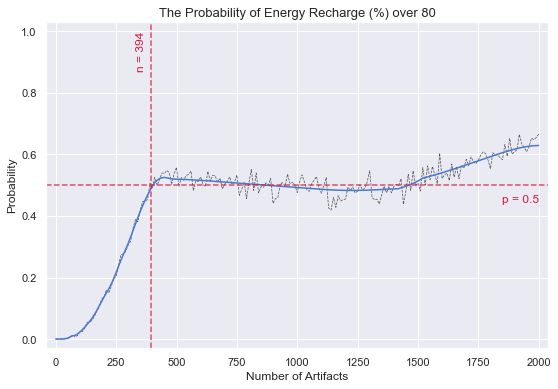

In [111]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(9,6))

x_values = df_summary["number"]
y_values = df_summary["prob0"]

# Smoothing
the_bound = 10
the_break1 = 39
the_break2 = 142
y_values_smooth_part1 = gaussian_filter1d(y_values[:the_bound], sigma=0.1)
y_values_smooth_part2 = gaussian_filter1d(y_values[:the_break1+the_bound], sigma=2)
y_values_smooth_part3 = gaussian_filter1d(y_values[the_break1:the_break2+the_bound], sigma=15)
y_values_smooth_part4 = gaussian_filter1d(y_values[the_break2:], sigma=10)
y_values_smooth = np.concatenate([
    [ (1-i/the_bound) * y_values_smooth_part1[i]  + (i/the_bound) * y_values_smooth_part2[i]
     for i in range(the_bound)], 
    y_values_smooth_part2[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part2[-the_bound+i]  + (i/the_bound) * y_values_smooth_part3[i]
     for i in range(the_bound)], 
    y_values_smooth_part3[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part3[-the_bound+i]  + (i/the_bound) * y_values_smooth_part4[i]
     for i in range(the_bound)], 
    y_values_smooth_part4[the_bound:]
])

ax.plot(x_values, y_values, '--', linewidth=0.7, color='k', alpha=0.75)
ax.plot(x_values, y_values_smooth)

# set x/y range
the_ymax = 1
the_xmax = 2000
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)

# red line p = 0.5
ax.axhline(0.5, ls='--', color='crimson', alpha=0.75)
plt.text(the_xmax, 0.5-the_ymax*0.03,'p = 0.5', 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=0)

the_keypoint0 = 394
# red line the number when p = 0.5
ax.axvline(the_keypoint0, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint0-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint0, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

ax.set(ylabel='Probability')
ax.set(xlabel='Number of Artifacts')
ax.set_title("The Probability of Energy Recharge (%) over 80", fontsize = 13)

plt.show()

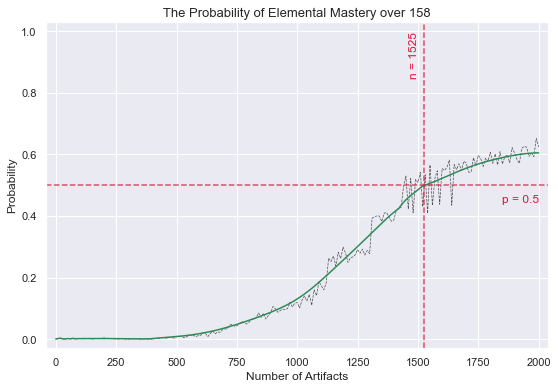

In [112]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(9,6))

x_values = df_summary["number"]
y_values = df_summary["prob1"]

# Smoothing
the_bound = 10
the_break1 = 39
the_break2 = 142
y_values_smooth_part1 = gaussian_filter1d(y_values[:the_bound], sigma=0.1)
y_values_smooth_part2 = gaussian_filter1d(y_values[:the_break1+the_bound], sigma=3)
y_values_smooth_part3 = gaussian_filter1d(y_values[the_break1:the_break2+the_bound], sigma=10)
y_values_smooth_part4 = gaussian_filter1d(y_values[the_break2:], sigma=10)
y_values_smooth = np.concatenate([
    [ (1-i/the_bound) * y_values_smooth_part1[i]  + (i/the_bound) * y_values_smooth_part2[i]
     for i in range(the_bound)], 
    y_values_smooth_part2[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part2[-the_bound+i]  + (i/the_bound) * y_values_smooth_part3[i]
     for i in range(the_bound)], 
    y_values_smooth_part3[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part3[-the_bound+i]  + (i/the_bound) * y_values_smooth_part4[i]
     for i in range(the_bound)], 
    y_values_smooth_part4[the_bound:]
])

ax.plot(x_values, y_values, '--', linewidth=0.7, color='k', alpha=0.75)
ax.plot(x_values, y_values_smooth, color='seagreen')

# set x/y range
the_ymax = 1
the_xmax = 2000
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)

# red line p = 0.5
ax.axhline(0.5, ls='--', color='crimson', alpha=0.75)
plt.text(the_xmax, 0.5-the_ymax*0.03,'p = 0.5', 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=0)

the_keypoint1 = 1525
# red line the number when p = 0.5
ax.axvline(the_keypoint1, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint1-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint1, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

ax.set(ylabel='Probability')
ax.set(xlabel='Number of Artifacts')
ax.set_title("The Probability of Elemental Mastery over 158", fontsize = 13)

plt.show()

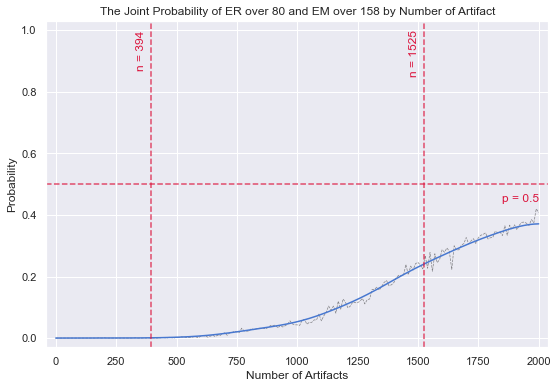

In [89]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(9,6))

x_values = df_summary["number"]
y_values = df_summary["prob_joined"]

# Smoothing
y_values_smooth = gaussian_filter1d(df_summary["prob_joined"], sigma=10)

ax.plot(x_values, y_values, '--', linewidth=0.7, color='k', alpha=0.5)
ax.plot(x_values, y_values_smooth)

# set x/y range
the_ymax = 1
the_xmax = 2000
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)

# red line of p = 0.5
ax.axhline(0.5, ls='--', color='crimson', alpha=0.75)
plt.text(the_xmax, 0.5-the_ymax*0.03,'p = 0.5', 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=0)

ax.axvline(the_keypoint0, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint0-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint0, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

ax.axvline(the_keypoint1, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint1-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint1, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

ax.set(ylabel='Probability')
ax.set(xlabel='Number of Artifacts')
ax.set_title("The Joint Probability of ER over 80 and EM over 158 by Number of Artifact")

plt.show()

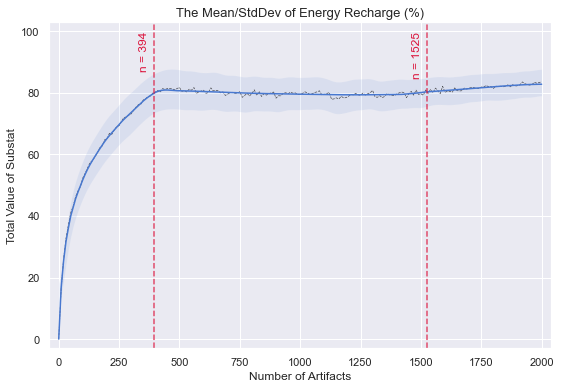

In [109]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(9,6))

x_values = df_summary["number"]
y_values = df_summary["mean0"]
err_values = df_summary["stddev0"]

# Smoothing
the_bound = 10
the_break1 = 39
the_break2 = 142
y_values_smooth_part1 = gaussian_filter1d(y_values[:the_bound], sigma=0.1)
y_values_smooth_part2 = gaussian_filter1d(y_values[:the_break1+the_bound], sigma=2)
y_values_smooth_part3 = gaussian_filter1d(y_values[the_break1:the_break2+the_bound], sigma=15)
y_values_smooth_part4 = gaussian_filter1d(y_values[the_break2:], sigma=10)
y_values_smooth = np.concatenate([
    [ (1-i/the_bound) * y_values_smooth_part1[i]  + (i/the_bound) * y_values_smooth_part2[i]
     for i in range(the_bound)], 
    y_values_smooth_part2[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part2[-the_bound+i]  + (i/the_bound) * y_values_smooth_part3[i]
     for i in range(the_bound)], 
    y_values_smooth_part3[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part3[-the_bound+i]  + (i/the_bound) * y_values_smooth_part4[i]
     for i in range(the_bound)], 
    y_values_smooth_part4[the_bound:]
])

# Error formating
upper_err = gaussian_filter1d(y_values + (err_values/2), sigma=2)
lower_err = gaussian_filter1d(y_values - (err_values/2), sigma=2)

ax.plot(x_values, y_values, '--', linewidth=0.7, color='k', alpha=0.75)
ax.plot(x_values, y_values_smooth)
ax.fill_between(x_values, upper_err, lower_err, alpha=0.1)

# set x/y range
the_ymax = 100
the_xmax = 2000
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)

# red line of keypoint

ax.axvline(the_keypoint0, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint0-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint0, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

ax.axvline(the_keypoint1, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint1-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint1, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)


ax.set(ylabel='Total Value of Substat')
ax.set(xlabel='Number of Artifacts')
ax.set_title("The Mean/StdDev of Energy Recharge (%)", fontsize = 13)

plt.show()

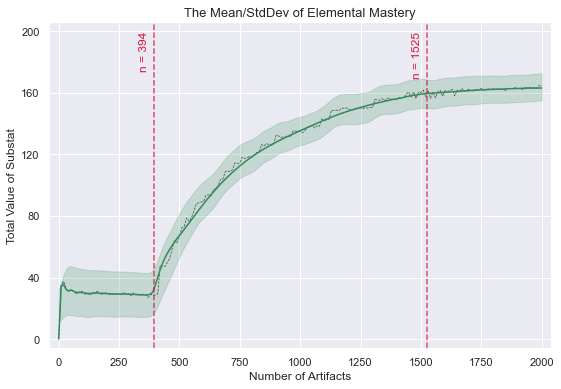

In [116]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(9,6))

x_values = df_summary["number"]
y_values = df_summary["mean1"]
err_values = df_summary["stddev1"]

# Smoothing
the_bound = 10
the_break1 = 39
the_break2 = 142
y_values_smooth_part1 = gaussian_filter1d(y_values[:the_bound], sigma=0.1)
y_values_smooth_part2 = gaussian_filter1d(y_values[:the_break1+the_bound], sigma=2)
y_values_smooth_part3 = gaussian_filter1d(y_values[the_break1:the_break2+the_bound], sigma=10)
y_values_smooth_part4 = gaussian_filter1d(y_values[the_break2:], sigma=10)
y_values_smooth = np.concatenate([
    [ (1-i/the_bound) * y_values_smooth_part1[i]  + (i/the_bound) * y_values_smooth_part2[i]
     for i in range(the_bound)], 
    y_values_smooth_part2[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part2[-the_bound+i]  + (i/the_bound) * y_values_smooth_part3[i]
     for i in range(the_bound)], 
    y_values_smooth_part3[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part3[-the_bound+i]  + (i/the_bound) * y_values_smooth_part4[i]
     for i in range(the_bound)], 
    y_values_smooth_part4[the_bound:]
])

# Error formating
upper_err = gaussian_filter1d(y_values + (err_values/2), sigma=2)
lower_err = gaussian_filter1d(y_values - (err_values/2), sigma=2)

ax.plot(x_values, y_values, '--', linewidth=0.7, color='k', alpha=0.75)
ax.plot(x_values, y_values_smooth, color='seagreen')
ax.fill_between(x_values, upper_err, lower_err, color='seagreen', alpha=0.2)

# set x/y range
the_ymax = 200
the_xmax = 2000
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)
ax.set_yticks([ idx * 40 for idx in range(6)])

# red line of keypoint
ax.axvline(the_keypoint0, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint0-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint0, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

# red line of keypoint
ax.axvline(the_keypoint1, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint1-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint1, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

ax.set(ylabel='Total Value of Substat')
ax.set(xlabel='Number of Artifacts')
ax.set_title("The Mean/StdDev of Elemental Mastery", fontsize = 13)

plt.show()

Text(0.5, 1.0, 'The Mean of Energy Recharge (%) and Elemental Mastery')

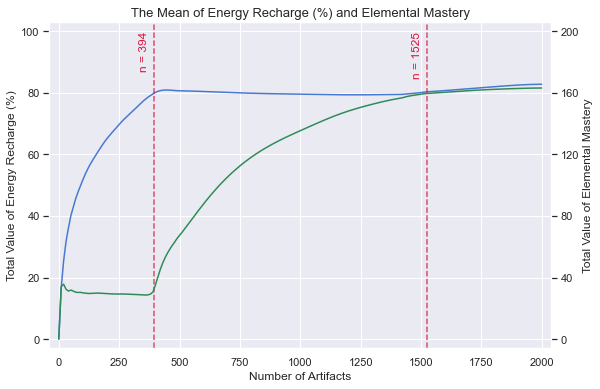

In [120]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(9,6))
ax1 = ax.twinx()

x_values = df_summary["number"]
y_values = df_summary["mean0"]
err_values = df_summary["stddev0"]
y_values1 = df_summary["mean1"]
err_values1 = df_summary["stddev1"]

# set x/y range
the_xmax = 2000
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)
the_ymax = 100
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
the_ymax1 = 200
ax1.set_ylim(-the_ymax1*0.03, the_ymax1*1.03)

# same grid
ax1.set_yticks([ idx * the_ymax1 / the_ymax for idx in ax.get_yticks()[1:-1]])
ax1.grid(None)


the_bound = 10
the_break1 = 39
the_break2 = 142
# Smoothing
y_values_smooth_part1 = gaussian_filter1d(y_values[:the_bound], sigma=0.1)
y_values_smooth_part2 = gaussian_filter1d(y_values[:the_break1+the_bound], sigma=2)
y_values_smooth_part3 = gaussian_filter1d(y_values[the_break1:the_break2+the_bound], sigma=15)
y_values_smooth_part4 = gaussian_filter1d(y_values[the_break2:], sigma=10)
y_values_smooth = np.concatenate([
    [ (1-i/the_bound) * y_values_smooth_part1[i]  + (i/the_bound) * y_values_smooth_part2[i]
     for i in range(the_bound)], 
    y_values_smooth_part2[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part2[-the_bound+i]  + (i/the_bound) * y_values_smooth_part3[i]
     for i in range(the_bound)], 
    y_values_smooth_part3[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part3[-the_bound+i]  + (i/the_bound) * y_values_smooth_part4[i]
     for i in range(the_bound)], 
    y_values_smooth_part4[the_bound:]
])

# Error formating
upper_err = gaussian_filter1d(y_values + (err_values/2), sigma=2)
lower_err = gaussian_filter1d(y_values - (err_values/2), sigma=2)

# ax.plot(x_values, y_values, '--', linewidth=0.7, color='k', alpha=0.75)
ax.plot(x_values, y_values_smooth)
# ax.fill_between(x_values, upper_err, lower_err, color='crimson', alpha=0.2)

# Smoothing
y_values_smooth1_part1 = gaussian_filter1d(y_values1[:the_bound], sigma=0.1)
y_values_smooth1_part2 = gaussian_filter1d(y_values1[:the_break1+the_bound], sigma=2)
y_values_smooth1_part3 = gaussian_filter1d(y_values1[the_break1:the_break2+the_bound], sigma=10)
y_values_smooth1_part4 = gaussian_filter1d(y_values1[the_break2:], sigma=10)
y_values_smooth1 = np.concatenate([
    [ (1-i/the_bound) * y_values_smooth1_part1[i]  + (i/the_bound) * y_values_smooth1_part2[i]
     for i in range(the_bound)], 
    y_values_smooth1_part2[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth1_part2[-the_bound+i]  + (i/the_bound) * y_values_smooth1_part3[i]
     for i in range(the_bound)], 
    y_values_smooth1_part3[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth1_part3[-the_bound+i]  + (i/the_bound) * y_values_smooth1_part4[i]
     for i in range(the_bound)], 
    y_values_smooth1_part4[the_bound:]
])

# Error formating
upper_err1 = gaussian_filter1d(y_values1 + (err_values1/2), sigma=2)
lower_err1 = gaussian_filter1d(y_values1 - (err_values1/2), sigma=2)

# ax1.plot(x_values, y_values1, '--', linewidth=0.7, color='k', alpha=0.75)
ax1.plot(x_values, y_values_smooth1, color='seagreen')
# ax1.fill_between(x_values, upper_err1, lower_err1, color='crimson', alpha=0.2)


# red line of keypoint

ax.axvline(the_keypoint0, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint0-the_xmax*0.01, the_ymax1, 'n = %d' % the_keypoint0, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

ax.axvline(the_keypoint1, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint1-the_xmax*0.01, the_ymax1, 'n = %d' % the_keypoint1, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)


ax.set(ylabel='Total Value of Energy Recharge (%)')
ax1.set(ylabel='Total Value of Elemental Mastery')
ax.set(xlabel='Number of Artifacts')

ax.set_title("The Mean of Energy Recharge (%) and Elemental Mastery", fontsize = 13)


# figures based on number of days
 - one set: 4 + 1
 - 1.07 artifacts per 20 resin

In [122]:
# 42 days

the_daily_number_of_artifacts = (180 * 42 + 60 * 6 - 30 * 6 * 3 + 60 * 5 ) / 42 / 20 * 1.07 * 0.6
the_daily_number_of_artifacts

5.869714285714285

In [123]:
the_keypoint0_by_day = the_keypoint0 / the_daily_number_of_artifacts
the_keypoint1_by_day = the_keypoint1 / the_daily_number_of_artifacts
the_keypoint0_by_day, the_keypoint1_by_day

(67.12422118380063, 259.80821651090343)

Text(0.5, 1.0, 'The Mean of Energy Recharge (%) and Elemental Mastery')

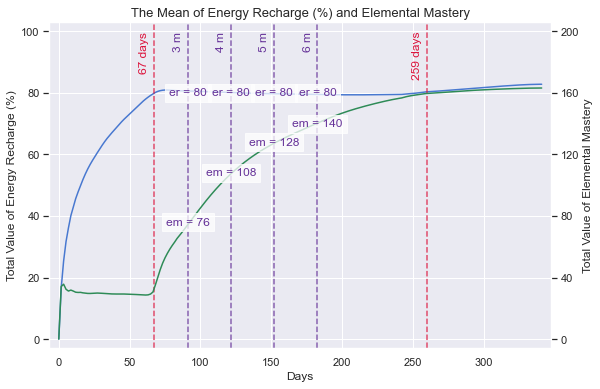

In [132]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(9,6))
ax1 = ax.twinx()

x_values = df_summary["number"] / the_daily_number_of_artifacts
y_values = df_summary["mean0"]
err_values = df_summary["stddev0"]
y_values1 = df_summary["mean1"]
err_values1 = df_summary["stddev1"]

# set x/y range
the_xmax = 2000 / the_daily_number_of_artifacts
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)
the_ymax = 100
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
the_ymax1 = 200
ax1.set_ylim(-the_ymax1*0.03, the_ymax1*1.03)

# same grid
ax1.set_yticks([ idx * the_ymax1 / the_ymax for idx in ax.get_yticks()[1:-1]])
ax1.grid(None)


the_bound = 10
the_break1 = 39
the_break2 = 142
# Smoothing
y_values_smooth_part1 = gaussian_filter1d(y_values[:the_bound], sigma=0.1)
y_values_smooth_part2 = gaussian_filter1d(y_values[:the_break1+the_bound], sigma=2)
y_values_smooth_part3 = gaussian_filter1d(y_values[the_break1:the_break2+the_bound], sigma=15)
y_values_smooth_part4 = gaussian_filter1d(y_values[the_break2:], sigma=10)
y_values_smooth = np.concatenate([
    [ (1-i/the_bound) * y_values_smooth_part1[i]  + (i/the_bound) * y_values_smooth_part2[i]
     for i in range(the_bound)], 
    y_values_smooth_part2[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part2[-the_bound+i]  + (i/the_bound) * y_values_smooth_part3[i]
     for i in range(the_bound)], 
    y_values_smooth_part3[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth_part3[-the_bound+i]  + (i/the_bound) * y_values_smooth_part4[i]
     for i in range(the_bound)], 
    y_values_smooth_part4[the_bound:]
])

# Error formating
upper_err = gaussian_filter1d(y_values + (err_values/2), sigma=2)
lower_err = gaussian_filter1d(y_values - (err_values/2), sigma=2)

# ax.plot(x_values, y_values, '--', linewidth=0.7, color='k', alpha=0.75)
ax.plot(x_values, y_values_smooth)
# ax.fill_between(x_values, upper_err, lower_err, color='crimson', alpha=0.2)

# Smoothing
y_values_smooth1_part1 = gaussian_filter1d(y_values1[:the_bound], sigma=0.1)
y_values_smooth1_part2 = gaussian_filter1d(y_values1[:the_break1+the_bound], sigma=2)
y_values_smooth1_part3 = gaussian_filter1d(y_values1[the_break1:the_break2+the_bound], sigma=10)
y_values_smooth1_part4 = gaussian_filter1d(y_values1[the_break2:], sigma=10)
y_values_smooth1 = np.concatenate([
    [ (1-i/the_bound) * y_values_smooth1_part1[i]  + (i/the_bound) * y_values_smooth1_part2[i]
     for i in range(the_bound)], 
    y_values_smooth1_part2[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth1_part2[-the_bound+i]  + (i/the_bound) * y_values_smooth1_part3[i]
     for i in range(the_bound)], 
    y_values_smooth1_part3[the_bound:-the_bound],
    [ (1-i/the_bound) * y_values_smooth1_part3[-the_bound+i]  + (i/the_bound) * y_values_smooth1_part4[i]
     for i in range(the_bound)], 
    y_values_smooth1_part4[the_bound:]
])

# Error formating
upper_err1 = gaussian_filter1d(y_values1 + (err_values1/2), sigma=2)
lower_err1 = gaussian_filter1d(y_values1 - (err_values1/2), sigma=2)

# ax1.plot(x_values, y_values1, '--', linewidth=0.7, color='k', alpha=0.75)
ax1.plot(x_values, y_values_smooth1, color='seagreen')
# ax1.fill_between(x_values, upper_err1, lower_err1, color='crimson', alpha=0.2)


# red line of keypoint

ax.axvline(the_keypoint0_by_day, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint0_by_day-the_xmax*0.01, the_ymax1, '%d days' % the_keypoint0_by_day, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

ax.axvline(the_keypoint1_by_day, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint1_by_day-the_xmax*0.01, the_ymax1, '%d days' % the_keypoint1_by_day, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

# 3 months
the_day = 365/12*3
ax.axvline(the_day, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day-the_xmax*0.01, the_ymax1, '3 m', 
         horizontalalignment='right', verticalalignment='top', color='rebeccapurple',rotation=90)

the_er = 80
# ax.axhline(the_er, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day, the_er*2,'er = %d' % the_er, 
         horizontalalignment='center', verticalalignment='center', color='rebeccapurple', rotation=0,
         bbox=dict(facecolor='w', alpha=0.75))

the_em = 76
# ax1.axhline(the_em, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day, the_em,'em = %d' % the_em, 
         horizontalalignment='center', verticalalignment='center', color='rebeccapurple',rotation=0,
         bbox=dict(facecolor='w', alpha=0.75))


# 4 months
the_day = 365/12*4
ax.axvline(the_day, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day-the_xmax*0.01, the_ymax1, '4 m', 
         horizontalalignment='right', verticalalignment='top', color='rebeccapurple',rotation=90)

the_er = 80
# ax.axhline(the_er, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day, the_er*2,'er = %d' % the_er, 
         horizontalalignment='center', verticalalignment='center', color='rebeccapurple', rotation=0,
         bbox=dict(facecolor='w', alpha=0.75))

the_em = 108
# ax1.axhline(the_em, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day, the_em,'em = %d' % the_em, 
         horizontalalignment='center', verticalalignment='center', color='rebeccapurple',rotation=0,
         bbox=dict(facecolor='w', alpha=0.75))


# 5 months
the_day = 365/12*5
ax.axvline(the_day, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day-the_xmax*0.01, the_ymax1, '5 m', 
         horizontalalignment='right', verticalalignment='top', color='rebeccapurple',rotation=90)

the_er = 80
# ax.axhline(the_er, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day, the_er*2,'er = %d' % the_er, 
         horizontalalignment='center', verticalalignment='center', color='rebeccapurple', rotation=0,
         bbox=dict(facecolor='w', alpha=0.75))

the_em = 128
# ax1.axhline(the_em, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day, the_em,'em = %d' % the_em, 
         horizontalalignment='center', verticalalignment='center', color='rebeccapurple',rotation=0,
         bbox=dict(facecolor='w', alpha=0.75))


# 6 months
the_day = 365/12*6
ax.axvline(the_day, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day-the_xmax*0.01, the_ymax1, '6 m', 
         horizontalalignment='right', verticalalignment='top', color='rebeccapurple',rotation=90)

the_er = 80
# ax.axhline(the_er, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day, the_er*2,'er = %d' % the_er, 
         horizontalalignment='center', verticalalignment='center', color='rebeccapurple', rotation=0,
         bbox=dict(facecolor='w', alpha=0.75))

the_em = 140
# ax1.axhline(the_em, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(the_day, the_em,'em = %d' % the_em, 
         horizontalalignment='center', verticalalignment='center', color='rebeccapurple',rotation=0,
         bbox=dict(facecolor='w', alpha=0.75))


ax.set(ylabel='Total Value of Energy Recharge (%)')
ax1.set(ylabel='Total Value of Elemental Mastery')
ax.set(xlabel='Days')
ax.set_title("The Mean of Energy Recharge (%) and Elemental Mastery", fontsize = 13)


In [103]:
the_er_count = 80 / (the_condition["unit_value"][0] * 0.85)
the_em_count = 80 / (the_condition["unit_value"][1] * 0.85)
the_er_count, the_em_count, the_er_count+the_em_count

(14.524328249818446, 4.039383993940924, 18.56371224375937)

In [104]:
the_er_count = 80 / (the_condition["unit_value"][0] * 0.85)
the_em_count = 144 / (the_condition["unit_value"][1] * 0.85)
the_er_count, the_em_count, the_er_count+the_em_count

(14.524328249818446, 7.270891189093663, 21.79521943891211)

In [105]:
the_er_count = 80 / (the_condition["unit_value"][0] * 0.85)
the_em_count = 158 / (the_condition["unit_value"][1] * 0.85)
the_er_count, the_em_count, the_er_count+the_em_count

(14.524328249818446, 7.977783388033325, 22.50211163785177)